In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

In [9]:
def load_dataset(base_dir, categories):
    data = []
    labels = []

    for category in categories:
        for subset in ['train', 'test', 'val']:
            subset_dir = os.path.join(base_dir, category, subset)
            for file_name in os.listdir(subset_dir):
                if file_name.endswith('.npy'):
                    file_path = os.path.join(subset_dir, file_name)
                    data.append(np.load(file_path))
                    labels.append(category)  

    return np.array(data), np.array(labels)

In [10]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)

    enc = OneHotEncoder( handle_unknown='ignore', sparse_output=False )
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = enc.fit_transform(integer_encoded)
    
    return onehot_encoded, label_encoder

In [11]:
base_dir = 'datasets'
categories = os.listdir(base_dir)

data, labels = load_dataset(base_dir, categories)
data = data.astype('float32') / 255.0  # Normalize the data

onehot_labels, label_encoder = encode_labels(labels)

train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    data, onehot_labels, test_size=0.3, random_state=42)
test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)

Train data shape: (2988, 70, 33, 3)
Train labels shape: (2988, 6)
Test data shape: (640, 70, 33, 3)
Test labels shape: (640, 6)
Validation data shape: (641, 70, 33, 3)
Validation labels shape: (641, 6)


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
def create_dataframe(labels):
    
    unique_labels = np.unique(labels)
    onehot_encoded, label_encoder = encode_labels(unique_labels)
    df_labels = pd.DataFrame(unique_labels, columns=['Original_Labels'])
    onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=label_encoder.classes_)
    
    df = pd.concat([df_labels, onehot_encoded_df], axis=1)
    
    return df

In [14]:
base_dir = 'datasets'
categories = os.listdir(base_dir)

data, labels = load_dataset(base_dir, categories)
# data = data.astype('float32') / 255.0  # Normalize the data

onehot_labels, label_encoder = encode_labels(labels)

train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    data, onehot_labels, test_size=0.3, random_state=42)
test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=0.5, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_data.shape[1:])

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)

model.fit(train_generator, epochs=100, validation_data=(val_data, val_labels))

test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc}")


Epoch 1/100


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.3469 - loss: 1.5951 - val_accuracy: 0.5335 - val_loss: 1.1672
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.6196 - loss: 1.0523 - val_accuracy: 0.6443 - val_loss: 0.9735
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.6742 - loss: 0.8858 - val_accuracy: 0.7223 - val_loss: 0.8109
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.6745 - loss: 0.8424 - val_accuracy: 0.7473 - val_loss: 0.7660
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.7178 - loss: 0.7732 - val_accuracy: 0.7332 - val_loss: 0.7264
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.7419 - loss: 0.7009 - val_accuracy: 0.7395 - val_loss: 0.7156
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.7385 - loss: 0.6957 - val_accuracy: 0.7629 - val_loss: 0.6701
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.7556 - loss: 0.6593 - val_accuracy

In [15]:
model.save('model.h5')
print("Model saved as exercise_classification_model.h5")
create_dataframe(categories)

Model saved as exercise_classification_model.h5


,Original_Labels,armraise,curl,legraise,overheadpress,pushup,squat
0,armraise,1.0,0.0,0.0,0.0,0.0,0.0
1,curl,0.0,1.0,0.0,0.0,0.0,0.0
2,legraise,0.0,0.0,1.0,0.0,0.0,0.0
3,overheadpress,0.0,0.0,0.0,1.0,0.0,0.0
4,pushup,0.0,0.0,0.0,0.0,1.0,0.0
5,squat,0.0,0.0,0.0,0.0,0.0,1.0


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step


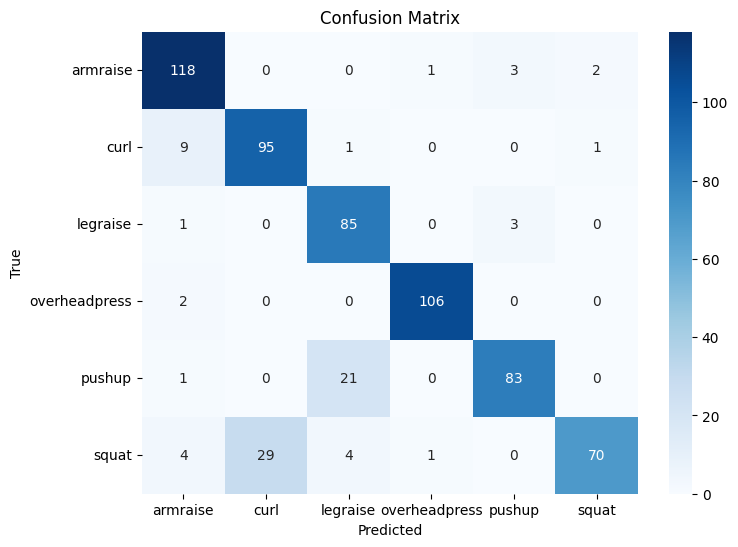

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()